<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/Hierarchical_Model_Energy_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Information**

https://archive.ics.uci.edu/dataset/242/energy+efficiency

We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

However, for this project - My aim to predict heating Load and use the "**Hierarchical Bayesian Model**"

**Additional Variable Information**
The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.

**Specifically:**

**X1	Relative Compactness**

**X2	Surface Area**

**X3	Wall Area**

**X4	Roof Area**

**X5	Overall Height**

**X6	Orientation**

**X7	Glazing Area**

**X8	Glazing Area Distribution**

**y1	Heating Load**

**y2	Cooling Load**

**License**

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.https://creativecommons.org/licenses/by/4.0/legalcode

This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.

In [27]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

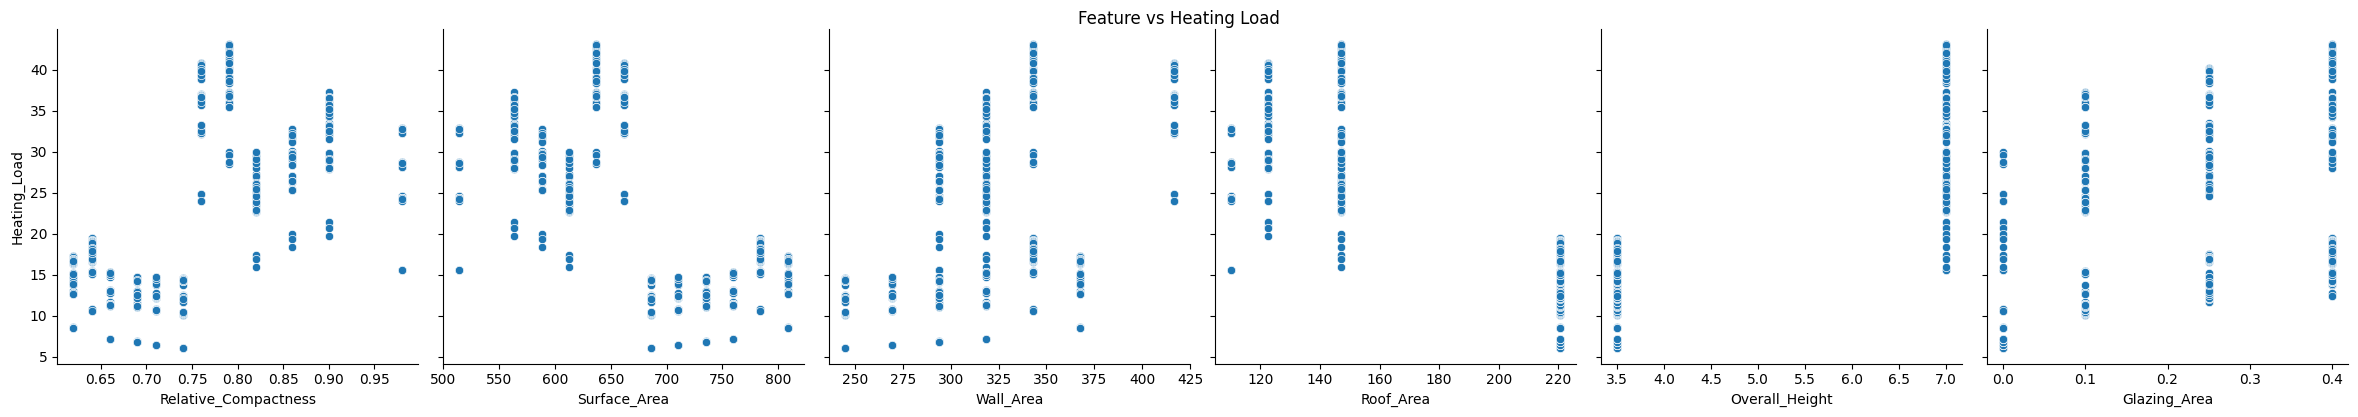

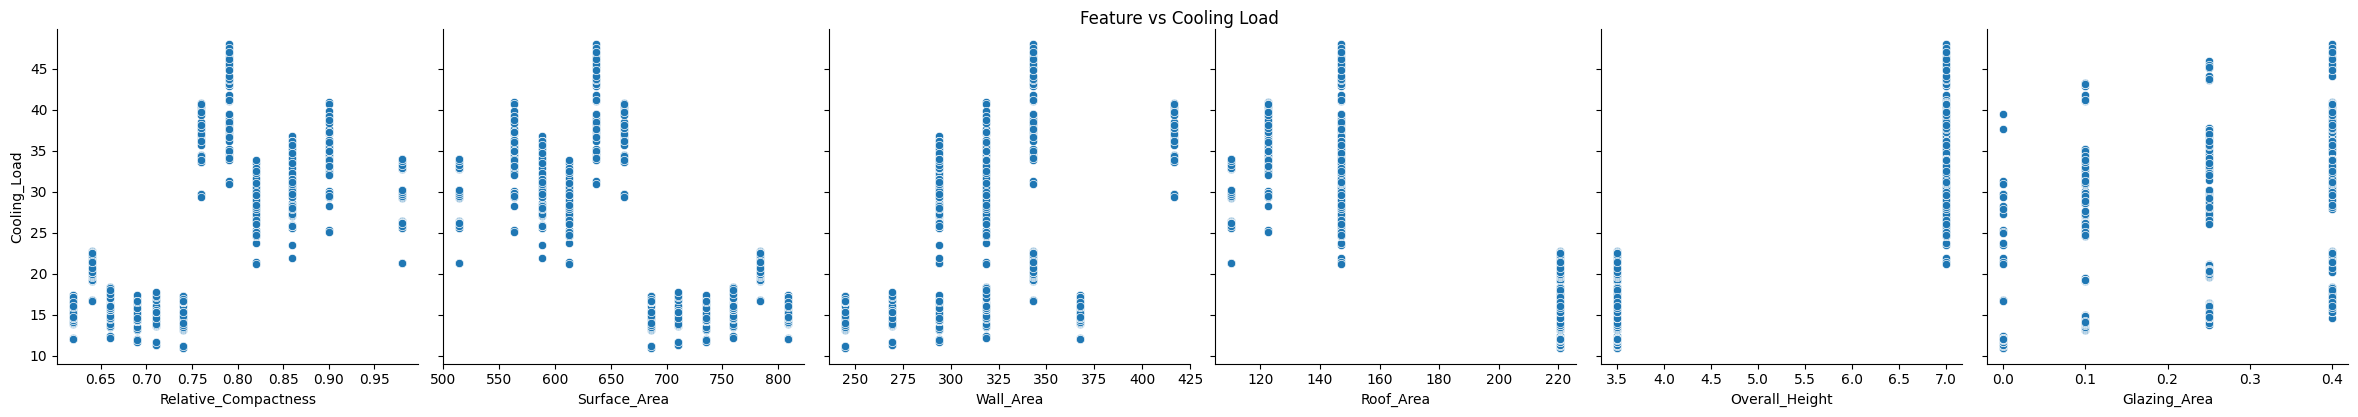

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to check linearity for heating load
sns.pairplot(df, x_vars=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area'],
             y_vars='Heating_Load', height=4, aspect=1)
plt.suptitle('Feature vs Heating Load', y=1.02)
plt.show()

# Pairplot for cooling load
sns.pairplot(df, x_vars=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area'],
             y_vars='Cooling_Load', height=4, aspect=1)
plt.suptitle('Feature vs Cooling Load', y=1.02)
plt.show()


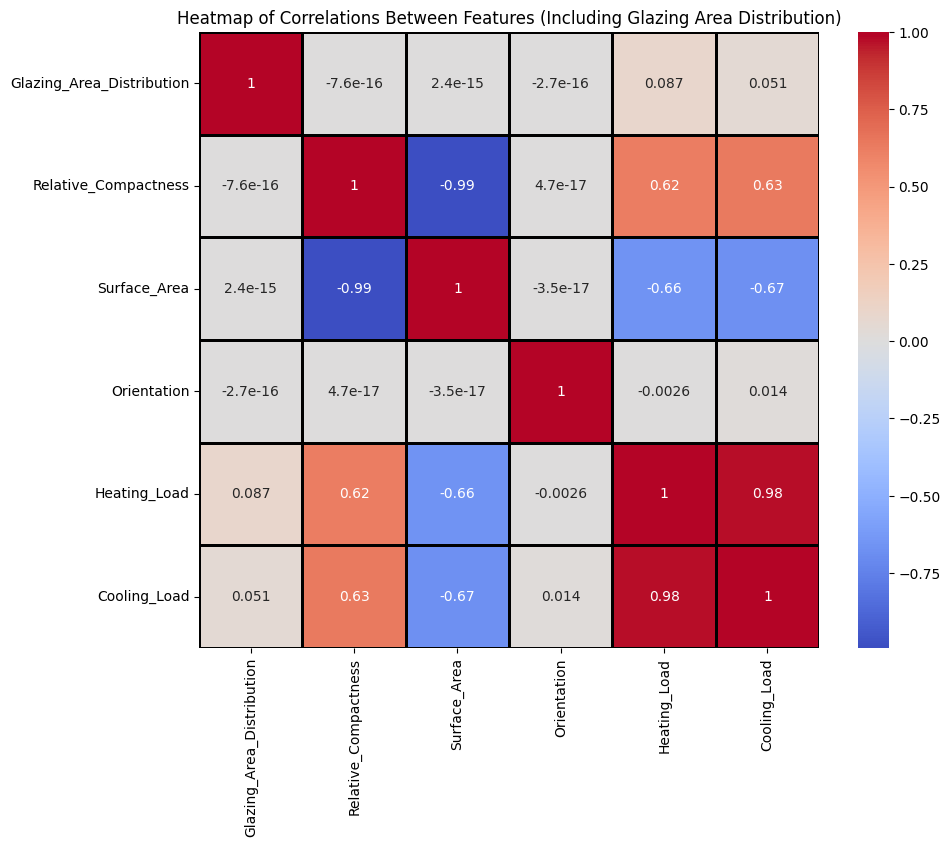

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant features for heatmap (including interactions)
interaction_features = ['Glazing_Area_Distribution', 'Relative_Compactness', 'Surface_Area',
                        'Orientation', 'Heating_Load', 'Cooling_Load']

# Create a new dataframe with these features
df_interaction = df[interaction_features]

# Generate the correlation matrix
corr_matrix_interaction = df_interaction.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_interaction, annot=True, cmap="coolwarm", center=0, linewidths=1, linecolor='black')
plt.title('Heatmap of Correlations Between Features (Including Glazing Area Distribution)')
plt.show()


In [30]:
# Correlation matrix for heating load
corr_matrix_heating = df.corr()['Heating_Load']
print(corr_matrix_heating)

# Correlation matrix for cooling load
corr_matrix_cooling = df.corr()['Cooling_Load']
print(corr_matrix_cooling)


Relative_Compactness         0.622272
Surface_Area                -0.658120
Wall_Area                    0.455671
Roof_Area                   -0.861828
Overall_Height               0.889430
Orientation                 -0.002587
Glazing_Area                 0.269842
Glazing_Area_Distribution    0.087368
Heating_Load                 1.000000
Cooling_Load                 0.975862
Name: Heating_Load, dtype: float64
Relative_Compactness         0.634339
Surface_Area                -0.672999
Wall_Area                    0.427117
Roof_Area                   -0.862547
Overall_Height               0.895785
Orientation                  0.014290
Glazing_Area                 0.207505
Glazing_Area_Distribution    0.050525
Heating_Load                 0.975862
Cooling_Load                 1.000000
Name: Cooling_Load, dtype: float64


RMSE for Heating Load: 8.688790204773113


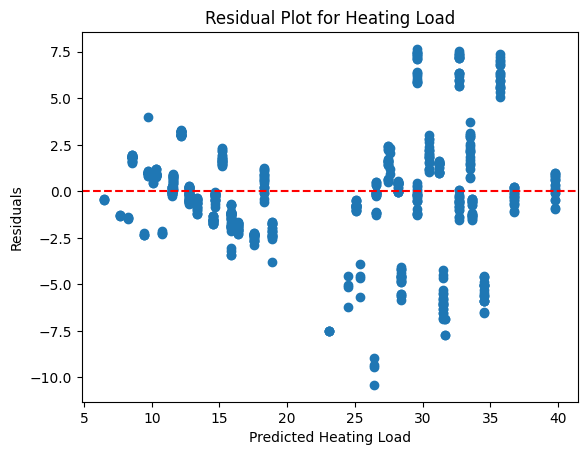

In [38]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Define features and target for heating load
X = df[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area']]
y_heating = df['Heating_Load']

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y_heating)
y_pred = lin_reg.predict(X)

# Calculate residuals
residuals = y_heating - y_pred
# Optionally, calculate the RMSE
rmse_log = mean_squared_error(y_heating, y_pred)
print("RMSE for Heating Load:", rmse_log)

# Plot residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Heating Load')
plt.xlabel('Predicted Heating Load')
plt.ylabel('Residuals')
plt.show()


In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit linear model on polynomial features
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y_heating)
y_pred_poly = lin_reg_poly.predict(X_poly)

# Compare the error of the linear and polynomial models
mse_linear = mean_squared_error(y_heating, y_pred)
mse_poly = mean_squared_error(y_heating, y_pred_poly)

print(f"Mean Squared Error (Linear): {mse_linear}")
print(f"Mean Squared Error (Polynomial): {mse_poly}")


Mean Squared Error (Linear): 8.688790204773113
Mean Squared Error (Polynomial): 0.8237948959974505


Output()

Output()

                   mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha           417.058  414.572     5.463   1175.558     12.393    8.765   
beta             12.309    9.616     0.818     30.192      0.243    0.172   
beta_linear[0]   46.494    4.705    37.832     56.060      0.085    0.060   
beta_linear[1]   15.795    7.671     0.656     30.611      0.153    0.108   
beta_linear[2]   19.106    3.767    11.899     26.541      0.084    0.060   
beta_linear[3]    6.317    7.852    -8.420     22.153      0.163    0.122   
beta_linear[4]  -15.015    6.345   -27.948     -3.044      0.182    0.131   
beta_linear[5]    2.267    0.107     2.062      2.474      0.002    0.001   
beta_quad[0]      8.388    1.188     6.172     10.839      0.034    0.024   
beta_quad[1]    -14.238    1.302   -16.828    -11.766      0.035    0.025   
beta_quad[2]      0.082    0.119    -0.152      0.303      0.003    0.002   
beta_quad[3]    -18.525    3.980   -26.277    -10.645      0.119    0.086   

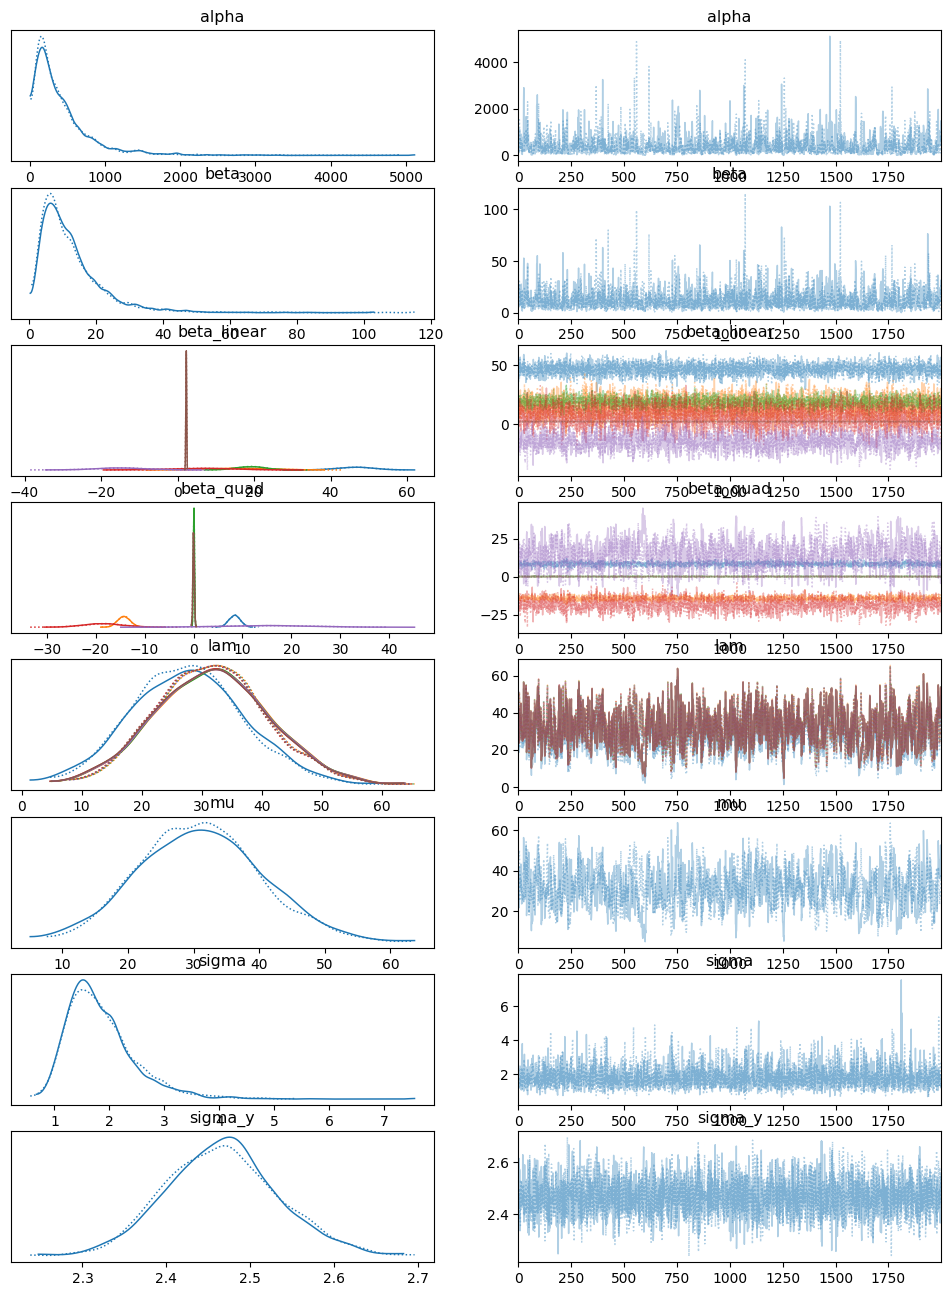

Output()

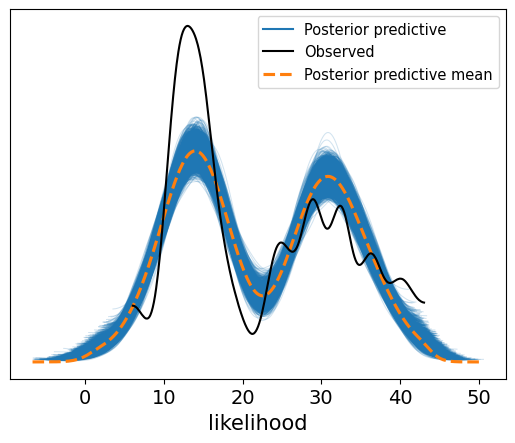

In [14]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area']]
X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']  # Assuming values are 0 to 5

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial Terms
with pm.Model(coords=COORDS) as hierarchical_model:
    # Hyperpriors: Priors for the group-level parameters (for glazing area distribution)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)  # Prior for group-level mean (mu)
    sigma = pm.Exponential('sigma', 1.0)  # Prior for group-level variance (sigma)

    # Parametrization for Gamma distribution
    alpha = pm.Deterministic('alpha', mu**2 / sigma**2)
    beta = pm.Deterministic('beta', mu / sigma**2)

    # Gamma prior for the group-level parameters (for each glazing area distribution)
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, dims='glazing_area')

    # Priors for individual-level coefficients (for linear and quadratic terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic model for heating load (group-level + individual-level effects)
    mu_y = lam[group_zero_indexed] + pm.math.dot(X_standardized, beta_linear) + pm.math.dot(X_squared, beta_quad)

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Trace plot for checking convergence
az.plot_trace(trace)
plt.show()
az.summary(trace, hdi_prob=0.95)

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# No need for from_pymc or from_pymc3
# 'ppc' already contains posterior predictive data in the InferenceData format

# Plot posterior predictive checks directly using ArviZ
az.plot_ppc(ppc)
plt.show()


In [17]:
# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=False)

# Extract the predicted values for the target variable (Heating Load)
predicted_heating_load = ppc['likelihood']

# Flatten the posterior predictive samples (combine chains and samples)
# Shape will become (4000, 768) after combining chains and samples
predicted_heating_load_flat = predicted_heating_load.reshape(-1, predicted_heating_load.shape[-1])

# Convert the 2D array into a pandas DataFrame
predicted_heating_load_df = pd.DataFrame(predicted_heating_load_flat)

# View summary statistics of the predictions
mean_predictions = predicted_heating_load_df.mean(axis=0)  # Mean of the posterior predictions
median_predictions = predicted_heating_load_df.median(axis=0)  # Median of the posterior predictions
lower_bound = predicted_heating_load_df.quantile(0.025, axis=0)  # Lower bound of 95% credible interval
upper_bound = predicted_heating_load_df.quantile(0.975, axis=0)  # Upper bound of 95% credible interval

# Print the summary statistics
print("Mean Predictions:\n", mean_predictions)
print("Median Predictions:\n", median_predictions)
print("95% Credible Interval (Lower Bound):\n", lower_bound)
print("95% Credible Interval (Upper Bound):\n", upper_bound)


Output()

Mean Predictions:
 0      20.093173
1      20.034408
2      20.023534
3      20.033765
4      22.272052
         ...    
763    17.874384
764    17.072910
765    17.075175
766    17.108636
767    17.069085
Length: 768, dtype: float64
Median Predictions:
 0      20.084167
1      20.038634
2      20.028004
3      20.044403
4      22.247818
         ...    
763    17.874421
764    17.075509
765    17.067894
766    17.145130
767    17.072532
Length: 768, dtype: float64
95% Credible Interval (Lower Bound):
 0      15.254860
1      15.059036
2      15.208218
3      15.181855
4      17.274178
         ...    
763    12.936798
764    12.150278
765    12.075926
766    12.181711
767    12.003010
Name: 0.025, Length: 768, dtype: float64
95% Credible Interval (Upper Bound):
 0      25.015512
1      25.043866
2      25.078892
3      24.860249
4      27.222697
         ...    
763    22.795828
764    21.834267
765    22.078712
766    21.959983
767    22.028796
Name: 0.975, Length: 768, dtype: float6

In [21]:

# Extract the actual heating load values from the dataset
actual_heating_load =y

# Calculate Mean Absolute Error (MAE) between actual and predicted mean values
mae = (mean_predictions - actual_heating_load).abs().mean()

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(((mean_predictions - actual_heating_load) ** 2).mean())

# Display the results
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 1.9584586894175835
Root Mean Square Error (RMSE): 2.4400530776737863


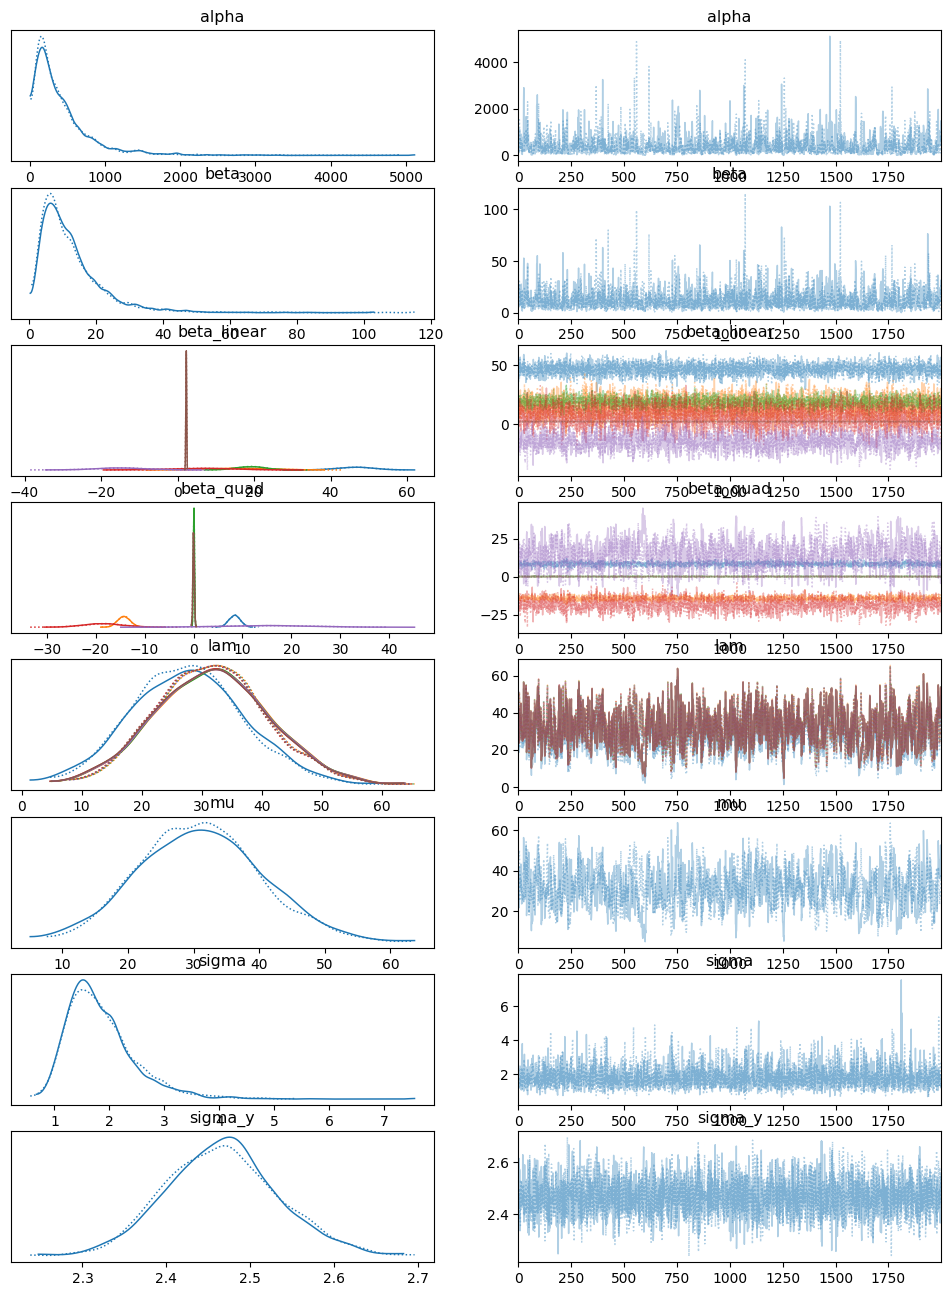

<xarray.Dataset> Size: 328B
Dimensions:            (beta_linear_dim_0: 6, beta_quad_dim_0: 6,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 48B 0 1 2 3 4 5
  * beta_quad_dim_0    (beta_quad_dim_0) int64 48B 0 1 2 3 4 5
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    alpha              float64 8B 1.0
    beta               float64 8B 1.0
    beta_linear        (beta_linear_dim_0) float64 48B 1.0 1.001 ... 1.001 1.0
    beta_quad          (beta_quad_dim_0) float64 48B 1.0 1.0 ... 1.001 1.001
    lam                (glazing_area) float64 48B 1.0 1.0 1.0 1.0 1.0 1.0
    mu                 float64 8B 1.001
    sigma              float64 8B 1.001
    sigma_y            float64 8B 1.0


In [31]:
# Plot the trace to visually inspect the model's convergence
az.plot_trace(trace)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)



In [32]:
# Calculate LOO for model evaluation
loo_result = az.loo(trace)
print(loo_result)


TypeError: log likelihood not found in inference data object